# **Summarisation & Evasion Notebook**

# **Handover Notes:** [delete after]
- Library imports and versions are saved in environments/summarisation_evasion_env.txt
- This notebook was originally built for a macbook pro M3 chip so some settings may need to be altered depending on your machine
- All files related/ generated by this notebook can be found in notebooks/summarisation_evasion_files

### **Work progress**
1. **Complete**
- Summarise banker answers using baseline model.
- Use Local RAG pipeline to bring in relevant external documents (PRA risk definitions) to create PRA aligned summaries.
- Developed a evasion detection prototype that generates evasion scores based on bankers answers (uses baseline model, LLM- natural language inference using RoBERTa and a blended score)
- Used jpm_2025 transcripts to get the pipeline working. Validated the evasion pipeline using jpm-23-1q data (involved human labelling the answer as Direct or Evasive- file saved in notebooks/summarisation_evasion_files).

2. **Not complete**
- Visualisations e.g. how many evasive answers were there? etc - apply evasion pipeline to dataset and generate statistics on evasiveness 
- Need to test pipleine on larger data set (e.g. jpm 2023-2025) and check against HSBC to make conclusions & comment on generalisability (answering research question: How does one bank’s tone and thematic profile compare to peers? Are divergences systemic or firm specific?)
- Summarisation pipeline could be improved using a two-stage pipeline: by first extractive summarisation to capture the context and details and then a second model to reframe the summary to be PRA and evasion aligned.
- Post-processing on the output file for the PRA aligned summaries by Mistral model so they are clearer- can this output be fed into another model to extract more insights/ detect evasion or risk?
- Increase the size of the validation set for the evasion pipeline prototype (e.g. more human labelling)
- Need to fine tune the evasion pipeline to increase accuracy
- Optional extensions e.g. using Agents, more complex RAG pipeline (including more useful context for the model), validation of instances of evasion using external news sources)

# 1. **Objectives**

# **2. Set up Workspace**

In [1]:
# Import libraries
# Core python
import os
import numpy as np
import pandas as pd
import re
import json
import pathlib
from pathlib import Path
from typing import List, Dict, Any 
import csv
import math
from collections import OrderedDict

# NLP & Summarisation
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from llama_cpp import Llama 
import torch
import torch.nn.functional as F

# Retrieval
from sentence_transformers import SentenceTransformer 

# ML
from sklearn.model_selection import train_test_split, GroupShuffleSplit, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, precision_recall_fscore_support, average_precision_score
from sklearn.isotonic import IsotonicRegression

# Visualisations
import matplotlib.pyplot as plt
import seaborn as sns 

# Set global SEED.
SEED = 42

/opt/homebrew/anaconda3/envs/nlp-evasion/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **3. Load the dataset**

In [2]:
# Load the dataset.
jpm_2025_df = pd.read_csv('../data/processed/jpm/all_jpm_2025.csv')

# View the data.
jpm_2025_df.head()

,question_number,answer_number,speaker_name,role,company,content,year,quarter,source_pdf
0,1,NaN,Ken Usdin,analyst,Autonomous Research,"Good morning, Jeremy. Wondering if you could s...",2025,Q1,data/raw/jpm/jpm-1q25-earnings-call-transcript...
1,1,1.0,Jeremy Barnum,Chief Financial Officer,JPMorganChase,"Sure, Ken. So I mean, at a high level, I would...",2025,Q1,data/raw/jpm/jpm-1q25-earnings-call-transcript...
2,2,NaN,Ken Usdin,analyst,Autonomous Research,Yeah. And just one question on the NII ex. Mar...,2025,Q1,data/raw/jpm/jpm-1q25-earnings-call-transcript...
3,2,1.0,Jeremy Barnum,Chief Financial Officer,JPMorganChase,"Yeah, that's a good question, Ken. You're righ...",2025,Q1,data/raw/jpm/jpm-1q25-earnings-call-transcript...
4,2,2.0,Jamie Dimon,Chairman & Chief Executive Officer,JPMorganChase,In the curve basically.,2025,Q1,data/raw/jpm/jpm-1q25-earnings-call-transcript...


# **4. Preprocessing**

- Used all_jpm_2025.csv dataset
- Preliminary preprocessing to label roles as analyst vs banker (invalid roles were corrected) to make downstream analysis easier. Created a new column 'role_normalised'.

In [3]:
# View speaker roles.
jpm_2025_df['role'].unique()

array(['analyst', 'Chief Financial Officer',
       'Chairman & Chief Executive Officer',
       'And then some. Theres a lot of value added.', 'Okay'],
      dtype=object)

In [4]:
# View rows with invalid roles.
valid_roles = 'analyst', 'Chief Financial Officer', 'Chairman & Chief Executive Officer'
invalid_roles_df = jpm_2025_df[~jpm_2025_df['role'].isin(valid_roles)]

# Number of rows with invalid roles.
print('Number of rows:', invalid_roles_df.shape[0])

# View the rows.
invalid_roles_df.head()

Number of rows: 2


,question_number,answer_number,speaker_name,role,company,content,year,quarter,source_pdf
201,35,5.0,"Chief Financial Officer, JPMorganChase",And then some. Theres a lot of value added.,JPMorganChase,"Yeah. And obviously, I mean, we're not going t...",2025,Q2,data/raw/jpm/jpm-2q25-earnings-call-transcript...
205,36,3.0,"Chief Financial Officer, JPMorganChase",Okay,there you have it.,"But it's not like I thought it would do badly,...",2025,Q2,data/raw/jpm/jpm-2q25-earnings-call-transcript...


In [5]:
# Input the correct role information.
jpm_2025_df.at[205, 'role'] = 'Chief Financial Officer'
jpm_2025_df.at[209, 'role'] = 'Chief Financial Officer'

# Verify the roles have been updated.
jpm_2025_df['role'].unique()

array(['analyst', 'Chief Financial Officer',
       'Chairman & Chief Executive Officer',
       'And then some. Theres a lot of value added.'], dtype=object)

In [6]:
# Define role mapping.
role_map = {
    'analyst': 'analyst',
    'Chief Financial Officer': 'banker',
    'Chairman & Chief Executive Officer': 'banker'
}

# Apply to dataset.
jpm_2025_df['role_normalised'] = jpm_2025_df['role'].map(role_map)

In [7]:
# View the dataset.
jpm_2025_df.head()

,question_number,answer_number,speaker_name,role,company,content,year,quarter,source_pdf,role_normalised
0,1,NaN,Ken Usdin,analyst,Autonomous Research,"Good morning, Jeremy. Wondering if you could s...",2025,Q1,data/raw/jpm/jpm-1q25-earnings-call-transcript...,analyst
1,1,1.0,Jeremy Barnum,Chief Financial Officer,JPMorganChase,"Sure, Ken. So I mean, at a high level, I would...",2025,Q1,data/raw/jpm/jpm-1q25-earnings-call-transcript...,banker
2,2,NaN,Ken Usdin,analyst,Autonomous Research,Yeah. And just one question on the NII ex. Mar...,2025,Q1,data/raw/jpm/jpm-1q25-earnings-call-transcript...,analyst
3,2,1.0,Jeremy Barnum,Chief Financial Officer,JPMorganChase,"Yeah, that's a good question, Ken. You're righ...",2025,Q1,data/raw/jpm/jpm-1q25-earnings-call-transcript...,banker
4,2,2.0,Jamie Dimon,Chairman & Chief Executive Officer,JPMorganChase,In the curve basically.,2025,Q1,data/raw/jpm/jpm-1q25-earnings-call-transcript...,banker


# **5. Summarisation**

## **5.1 Baseline**

- Initial model exploration using BART and mistral-7B-instruct to summarise banker's answers (no additional context given to model)

### **5.1.1 BART**

In [8]:
# Filter data to banker answers only.
banker_answers = jpm_2025_df[jpm_2025_df['role_normalised'] == 'banker']['content'].tolist()
print(banker_answers[0][:200])

Sure, Ken. So I mean, at a high level, I would say that obviously, some of the salient news flow is quite recent. So, we've done some soundings and some checking both on the consumer side and on the w


In [9]:
# Summarisation baseline (BART)
bart = pipeline('summarization', model='facebook/bart-large-cnn')

sample_text = banker_answers[0]
summary_bart = bart(sample_text, max_length=80, min_length=30, do_sample=False)
print('Original:', sample_text[:400])
print('Summary:', summary_bart[0]['summary_text'])

Device set to use mps:0


Original: Sure, Ken. So I mean, at a high level, I would say that obviously, some of the salient news flow is quite recent. So, we've done some soundings and some checking both on the consumer side and on the wholesale side. I think on the consumer side, the thing to check is the spending data. And to be honest, the main thing that we see there, what would appear to be a certain amount of frontloading of sp
Summary: The main thing that we see there, what would appear to be a certain amount of frontloading of spending ahead of people expecting price increases from tariffs. So ironically, that's actually somewhat supportive, all else equal. In terms of our corporate clients, obviously, they've been reacting to the changes in tariff policy.


- bart was able to extract ket ideas, focussing on fronloading of spending and tariff policy. 
- Compressed the response into two sentences and the summary is coherent, removing filler phrases.
- However, the summary is not fully neutral (e.g. includes ironically) and preserves tone
- Also there is a loss of context- e.g. consumer side vs wholesale side distinction is no longer explicit.

In [10]:
# Prompt conditioning to make PRA relevant.
prompt = "Summarise this answer, focusing on risk, capital and evasion of detail: " + sample_text
summary_bart_prompted = bart(prompt, max_length=80, min_length=30)
print('Original:', sample_text[:400])
print('Summary:', summary_bart_prompted[0]['summary_text'])

Original: Sure, Ken. So I mean, at a high level, I would say that obviously, some of the salient news flow is quite recent. So, we've done some soundings and some checking both on the consumer side and on the wholesale side. I think on the consumer side, the thing to check is the spending data. And to be honest, the main thing that we see there, what would appear to be a certain amount of frontloading of sp
Summary: Corporates are taking a wait-and-see approach to tariff policy. Some sectors are going to be much more exposed than others. Small business and smaller corporates are probably a little more challenged.


- Prompted summary shifts emphasis and includes interpretation around risk, even though those words were no explicit in the original
- This version is more aligned to evasion detection but moves away from concrete detail 
- Improved approach would be to have a two stage-pipeline: first extractive summarisation to capture the context and details and then a second model to reframe the summary to be PRA and evasion aligned.

### **5.1.2 Mistral-7B-Instruct**

- Mistral model: mistral-7b-instruct-v0.1.Q4_K_M.gguf
- Mistral-7B-Instruct model download: https://huggingface.co/TheBloke/Mistral-7B-Instruct-v0.1-GGUF?show_file_info=mistral-7b-instruct-v0.1.Q4_K_M.gguf
- Also saved in shared team folder models

In [11]:
# Summarisation baseline (Mistral-7B-Instruct) with basic prompt.
llm = Llama(model_path='/Users/laurenbrixey/Documents/Data Science Career Accelerator/Project Submissions/Course 3/topic_project_4.1/mistral-7b-instruct-v0.1.Q4_K_M.gguf',
            n_ctx=4096, n_gpu_layers=-1, verbose=False, seed=SEED)  # change path as needed 

prompt = f"<s>[INST] Summarise the following answer in 2 sentences, focusing on concrete facts. Avoid opinions.\n\n{sample_text}\n[/INST]"

output = llm.create_chat_completion(
    messages=[{'role': 'user', 'content': prompt}],
    max_tokens=180,
    temperature=0.1,
    stop=['</s>']
)

summary_mistral = output['choices'][0]['message']['content'].strip()  

print('Original:', sample_text[:400])
print('Summary:', summary_mistral)

llama_context: n_ctx_per_seq (4096) < n_ctx_train (32768) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64 

Original: Sure, Ken. So I mean, at a high level, I would say that obviously, some of the salient news flow is quite recent. So, we've done some soundings and some checking both on the consumer side and on the wholesale side. I think on the consumer side, the thing to check is the spending data. And to be honest, the main thing that we see there, what would appear to be a certain amount of frontloading of sp
Summary: The speaker is discussing the impact of recent news flow on the consumer and corporate sides. On the consumer side, there has been some frontloading of spending ahead of expected price increases from tariffs, which may distort the data and make it difficult to draw larger conclusions. On the corporate side, clients are reacting to changes in tariff policy by shifting their focus towards short-term work and optimizing supply chains. The speaker characterizes the attitude of corporate clients as a wait-and-see attitude, with smaller clients and smaller corporates being more c

- Preserves details and nuance and is more contextual and interpretive than the BART baseline model.
- However, the result is longer with heavier phrasing and includes phrases like 'distort the data' which is not explicit in the original.

In [12]:
# Summarisation baseline (Mistral-7B-Instruct) with more detailed prompt.
llm = Llama(model_path='/Users/laurenbrixey/Documents/Data Science Career Accelerator/Project Submissions/Course 3/topic_project_4.1/mistral-7b-instruct-v0.1.Q4_K_M.gguf',
            n_ctx=4096, n_gpu_layers=-1, verbose=False, seed=SEED)  # change path as needed 

prompt = f"<s>[INST] Summarise the following answer in 2 sentences, focusing on concrete facts. Avoid opinions. Focus on risk, capital and evasion of detail.\n\n{sample_text}\n[/INST]"

output = llm.create_chat_completion(
    messages=[{'role': 'user', 'content': prompt}],
    max_tokens=180,
    temperature=0.1,
    stop=['</s>']
)

summary_mistral_prompted = output['choices'][0]['message']['content'].strip()  

print('Original:', sample_text[:400])
print('Summary:', summary_mistral_prompted)

llama_context: n_ctx_per_seq (4096) < n_ctx_train (32768) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64 

Original: Sure, Ken. So I mean, at a high level, I would say that obviously, some of the salient news flow is quite recent. So, we've done some soundings and some checking both on the consumer side and on the wholesale side. I think on the consumer side, the thing to check is the spending data. And to be honest, the main thing that we see there, what would appear to be a certain amount of frontloading of sp
Summary: The speaker is discussing the impact of recent news flow on the consumer and corporate sides of their business. On the consumer side, they have observed some frontloading of spending ahead of expected price increases from tariffs, which may distort data and make it difficult to draw larger conclusions. On the corporate side, clients are shifting their focus towards optimizing supply chains and responding to the current environment, rather than prioritizing more strategic work. The speaker notes that smaller clients and smaller corporates may be more challenged than larger o

- This summary brings in risk- language and is closer to the task objective.
- However, some interpretations are generated by the model rather than explicitly detailed in the answer

## **5.2 Adding Context**

Retrieve PRA risk categories to give greater PRA focus to summaries (local RAG loop).
- measure cosine similarity between transcript chunks and PRA risk categories (vectors)
- retrieve the top 2-3 most relevant risk categories 
- prepend them to the summarisation prompt to make summaries PRA-aligned instead of just summarised answers

- Attempting to use BART resulted in prompt echoing.
- New attempt using Mistral-7B-Instruct.
- Using sentence-BERT vs TF-IDF for vectorisation.

### **5.2.1 Mistral-7B-Instruct**

**Process**
- Performed some light cleaning of the transcript to remove whitespace.
- Split the transcript into smaller chunks that the model can summarise to avoid truncation
- Loaded the PRA categories csv file (contains category and definition)
- Embedded the PRA categories and chunks, evaluated the similarity to extract the PRA risk categories that were relevant to the text
- Summarised the chunk using detailed prompted and relevant PRA categories as additional context. 

**Output File**:
- The output file of this can be found in notebooks/summarisation_evasion_files, name = jpm_mistral_pra_summary.json
- It is in the format: summary, evidence, PRA category that relates to summary and reasoning for selecting these categories.

- Needed to use a lot of fine tuning for the prompt and set strict rules for the model
- Need to be very clear about the output expected or else the model deviates a lot, especially as it processes more data.
- Include lines about lack of evidence if not the model may hallucinate

In [13]:
# Function to remove whitespace in text.
def clean_text(text: str):
    return re.sub(r'\s+', ' ', text).strip()

In [14]:
# Function to split the transcript into smaller chunks.
def chunk_text(text: str, max_chars: int = 6000):
    sentences = re.split(r'(?<=[.!?])\s+', text.strip()) # split into sentences 
    chunks, current_chunk, current_len = [], [], 0 # list of chunks, sentences collecting for current chunk, character count for current chunk

    for s in sentences:
        if current_len + len(s) + 1 <= max_chars: # if the characters of current chunk + new sentence is below the limit:
            current_chunk.append(s) # add sentence to current chunk 
            current_len += len(s) + 1 # update running character count 
        
        else: # if the characters is above the limit:
            chunks.append(' '.join(current_chunk)) # add the current chunk to the final chunk list
            current_chunk, current_len = [s], len(s) # start a new chunk containing the sentence and update current len

    if current_chunk:
        chunks.append(' '.join(current_chunk)) # add any sentences in current chunk after loop ends 

    return chunks 

In [15]:
# Function to load PRA categories and definitions from CSV.
def load_pra_categories(path: Path):
    with open(path, newline='', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        return [
            (row.get('category', '').strip(), [row.get('definition', '').strip()])
            for row in reader if row.get('category')
        ]

In [16]:
# Build a Sentence-BERT embedding index for PRA categories.
def build_embedding_index(pra_categories):
    embedder = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    docs = [f"{name} {' '.join(defs)}" for name, defs in pra_categories]
    pra_risk_embeddings = embedder.encode(docs, batch_size=32, normalize_embeddings=True)

    return embedder, np.asarray(pra_risk_embeddings)

In [17]:
# Function to find the relevant PRA categories to the transcript chunks.
def find_rel_categories(chunk, pra_categories, embedder, pra_risk_embeddings, top_k=2):
    query_vec = embedder.encode([chunk], normalize_embeddings=True) # turns chunk into embedding
    sims = cosine_similarity(query_vec, pra_risk_embeddings).ravel() # compares the chunk to each category doc 
    top_indices = np.argsort(-sims)[:top_k] # sorts scores descending and selected top k cateogories 

    return [pra_categories[i] for i in top_indices]

In [18]:
# Function to parse JSON
def parse_tagged_json(raw):
    m = re.search(r"<json>\s*(\{[\s\S]*?\})\s*</json>", raw, flags=re.IGNORECASE)
    if not m:
        return None
    try:
        return json.loads(m.group(1))
    except json.JSONDecodeError:
        return None

In [19]:
# Function to summarise the text chunks.
def summarise_chunk(model, chunk, relevant_categories, max_evidence=5):

    # Build PRA notes (limit to 2 bullets per category)
    lines = []
    for name, definition in relevant_categories:
        lines.append(f'- {name}:')
        for d in list(definition)[:2]:
            lines.append(f'- {d}')
    notes_block = '\n'.join(lines)

    system_prompt = (
        "You are a careful data extraction model. "
        "Return ONLY valid JSON wrapped in <json>...</json> tags."
    )

    user_prompt = f"""
TRANSCRIPT:
{chunk}

PRA NOTES:
{notes_block}

TASK:
Return JSON ONLY, wrapped exactly like this:
<json>{{"summary": "...", "evidence": ["..."], "pra_categories": [{{"category":"...","why":"..."}}]}}</json>

RULES:
- 4-6 sentence neutral summary.
- Up to {max_evidence} evidence bullets (quotes/facts).
- 1-3 pra_categories objects.
- If evidence is lacking, use a single bullet "Insufficient evidence".
- Only choose categories supported by the evidence.
""".strip()

    response = model.create_chat_completion(
        messages=[
            {'role': 'system', 'content': system_prompt},
            {'role': 'user', 'content': user_prompt},
        ],
        temperature=0.2,
        top_p=0.9,
        max_tokens=700,
        repeat_penalty=1.1,
    )

    raw = (response['choices'][0]['message']['content'] or '').strip()

    # Parse the tagged JSON
    parsed = parse_tagged_json(raw)

    # Fallback if model didn’t follow instructions
    if not parsed:
        return (
            {'summary': '', 'evidence': ['Insufficient evidence'], 'pra_categories': []},
            raw,
        )

    # Light coercion to guarantee keys exist
    result = {
        'summary': parsed.get('summary', '') or '',
        'evidence': parsed.get('evidence', []) or [],
        'pra_categories': parsed.get('pra_categories', []) or []
    }
    return result, raw

In [20]:
# Define variables.
MODEL_PATH = '/Users/laurenbrixey/Documents/Data Science Career Accelerator/Project Submissions/Course 3/topic_project_4.1/mistral-7b-instruct-v0.1.Q4_K_M.gguf'
PRA_NOTES_PATH = '../data/RAG-resources/PRA_risk_categories.csv'
TRANSCRIPT_PATH = '../data/processed/jpm/all_jpm_2025.csv'
OUTPUT_PATH = pathlib.Path('../notebooks/summarisation_evasion_files/jpm_mistral_pra_summary_raw.json')
TOP_K = 2

In [21]:
# Runner code.
pra_categories = load_pra_categories(Path(PRA_NOTES_PATH))
embedder, category_embeddings = build_embedding_index(pra_categories)

# Load and chunk transcript
transcript_text = Path(TRANSCRIPT_PATH).read_text(encoding='utf-8')
transcript_chunks = chunk_text(transcript_text)

n_threads = max(4, (os.cpu_count() or 8) - 2)

# Define the model.
model = Llama(
    model_path=str(MODEL_PATH),
    n_ctx=4096,
    n_gpu_layers=20,
    chat_format='mistral-instruct',
    n_threads=n_threads,
)

raw_outputs = []

for i, chunk in enumerate(transcript_chunks, 1):
    try:
        top_categories = find_rel_categories(
            chunk, pra_categories, embedder, category_embeddings, top_k=TOP_K
        )
        _, raw = summarise_chunk(
            model, chunk, top_categories, max_evidence=5
        )
        raw_outputs.append({'chunk': i, 'raw': raw})

    except Exception:
        raw_outputs.append({'chunk': i, 'raw': ''})

final_output = {'raw_outputs': raw_outputs}

OUTPUT_PATH.write_text(json.dumps(final_output, indent=2, ensure_ascii=False), encoding='utf-8')
print(f'Wrote final JSON to: {OUTPUT_PATH.resolve()}')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
llama_model_load_from_file_impl: using device Metal (Apple M3) - 3559 MiB free
llama_model_loader: loaded meta data with 20 key-value pairs and 291 tensors from /Users/laurenbrixey/Documents/Data Science Career Accelerator/Project Submissions/Course 3/topic_project_4.1/mistral-7b-instruct-v0.1.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.1
llama_model_loader: - kv   2

KeyboardInterrupt: 

- Need to preprocess the output so it is visually clearer (summary, evidence, PRA categories (name & why the model chose this))
- Can this information be fed to the model again and can it detect any early PRA risk indicators?

# **6. Evasion Detection Pipeline**

1. **Baseline Evasion score** (rule-based) is made up of three components:
- **Cosine similarity**- similarity of the question and answer, lower similarity = more evasive
- **Numeric specificity check**- does the question require a number, if so does the answer contain a number?, e.g. requests for financial data
- **Evasive phrases**- does the answer contain evasive phrases?, presence = more evasive

2. **LLM evasion score** (RoBERTa-MNLI) uses entailment/neutral/contradiction between the question and answer
- Lower entailment (and higher neutral + contradiction) = more evasive
  
3. **Blended evasion score** combines both scores including a weight for the LLM component
- Rationale is that baseline enforces precision while the LLM will capture semantics

## **6.1. JPM**

### **6.1.1 Data Preprocessing**

In [2]:
# Load dataset
all_jpm_2023_2025 = pd.read_csv('../data/processed/jpm/all_jpm_2023_2025.csv')

# View dataset.
display(all_jpm_2023_2025.head())

# Number of rows.
print('Number of rows:', all_jpm_2023_2025.shape[0])

,section,question_number,answer_number,speaker_name,role,company,content,year,quarter,is_pleasantry,source_pdf
0,presentation,NaN,NaN,Jeremy Barnum,Chief Financial Officer,JPMorganChase,"Thanks, and good morning, everyone. The presen...",2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...
1,qa,NaN,NaN,Steven Chubak,analyst,Wolfe Research LLC,"Hey, good morning.",2023,Q1,True,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...
2,qa,NaN,NaN,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,"Good morning, Steve.",2023,Q1,True,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...
3,qa,1.0,NaN,Steven Chubak,analyst,Wolfe Research LLC,"So, Jamie, I was actually hoping to get your p...",2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...
4,qa,1.0,1.0,Jamie Dimon,Chairman & Chief Executive Officer,JPMorgan Chase & Co.,"Well, I think you were already kind of complet...",2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...


Number of rows: 1411


In [3]:
# Remove pleasantries.
all_jpm_2023_2025_cleaned = all_jpm_2023_2025[all_jpm_2023_2025['is_pleasantry'] == False]
print('Number of rows:', all_jpm_2023_2025_cleaned.shape[0])

Number of rows: 1241


In [4]:
# Check content column.
print('Number of rows with no content:', all_jpm_2023_2025_cleaned['content'].isna().sum())

Number of rows with no content: 23


In [5]:
# Drop rows with no content.
all_jpm_2023_2025_cleaned = all_jpm_2023_2025_cleaned.dropna(subset=['content'])

In [6]:
# Check content column.
print('Number of rows with no content:', all_jpm_2023_2025_cleaned['content'].isna().sum())

Number of rows with no content: 0


In [7]:
# View roles.
all_jpm_2023_2025_cleaned['role'].unique()

array(['Chief Financial Officer', 'analyst',
       'Chairman & Chief Executive Officer',
       'And then some. Theres a lot of value added.', 'Okay',
       "We're fundamentally", 'Thanks', 'Almost no chance.'], dtype=object)

- Some text has leaked into role column.

In [8]:
# View rows with invalid roles. 
valid_roles = 'analyst', 'Chief Financial Officer', 'Chairman & Chief Executive Officer'
invalid_roles_df = all_jpm_2023_2025_cleaned[~all_jpm_2023_2025_cleaned['role'].isin(valid_roles)]
invalid_roles_df.head(10)

,section,question_number,answer_number,speaker_name,role,company,content,year,quarter,is_pleasantry,source_pdf
305,qa,22.0,4.0,"Chief Financial Officer, JPMorganChase",And then some. Theres a lot of value added.,JPMorganChase,"Yeah. And obviously, I mean, we're not going t...",2025,Q2,False,data/raw/jpm/.ipynb_checkpoints/jpm-2q25-earni...
309,qa,23.0,3.0,"Chief Financial Officer, JPMorganChase",Okay,there you have it.,"But it's not like I thought it would do badly,...",2025,Q2,False,data/raw/jpm/.ipynb_checkpoints/jpm-2q25-earni...
650,qa,10.0,3.0,Who knows how important politics are in all th...,We're fundamentally,"as I said, I think on the press call, happy to...",little bit cautious about the pull-forward dyn...,2024,Q1,False,data/raw/jpm/jpm-1q24-earnings-call-transcript...
924,qa,8.0,2.0,"Chief Financial Officer, JPMorgan Chase & Co.",Thanks,Glenn.,"Operator: Next, we'll go to the line of Matt O...",2024,Q2,False,data/raw/jpm/jpm-2q24-earnings-call-transcript...
1059,qa,22.0,4.0,"Chief Financial Officer, JPMorganChase",And then some. Theres a lot of value added.,JPMorganChase,"Yeah. And obviously, I mean, we're not going t...",2025,Q2,False,data/raw/jpm/jpm-2q25-earnings-call-transcript...
1063,qa,23.0,3.0,"Chief Financial Officer, JPMorganChase",Okay,there you have it.,"But it's not like I thought it would do badly,...",2025,Q2,False,data/raw/jpm/jpm-2q25-earnings-call-transcript...
1274,qa,23.0,1.0,"Chairman & Chief Executive Officer, JPMorgan C...",Almost no chance.,JPMorganChase,"Well, but having – it's very important. While ...",2024,Q3,False,data/raw/jpm/jpm-3q24-earnings-conference-call...


In [9]:
# Input the correct role information.
all_jpm_2023_2025_cleaned.loc[[305, 309, 924, 1059, 1063], 'role'] = 'Chief Financial Officer'
all_jpm_2023_2025_cleaned.loc[[1274], 'role'] = 'Chairman & Chief Executive Officer'

# Drop nonsence row.
all_jpm_2023_2025_cleaned = all_jpm_2023_2025_cleaned.drop(index=650)

In [10]:
# Check the roles have been updated.
all_jpm_2023_2025_cleaned['role'].unique()

array(['Chief Financial Officer', 'analyst',
       'Chairman & Chief Executive Officer'], dtype=object)

In [11]:
# Normalise role names.
role_map = {
    'analyst': 'analyst',
    'Chief Financial Officer': 'banker',
    'Chairman & Chief Executive Officer': 'banker'
}

# Map roles.
all_jpm_2023_2025_cleaned['role_normalised'] = all_jpm_2023_2025_cleaned['role'].map(role_map)

In [12]:
# View dataset.
display(all_jpm_2023_2025_cleaned.head())
print('Number of rows:', all_jpm_2023_2025_cleaned.shape[0])

,section,question_number,answer_number,speaker_name,role,company,content,year,quarter,is_pleasantry,source_pdf,role_normalised
0,presentation,NaN,NaN,Jeremy Barnum,Chief Financial Officer,JPMorganChase,"Thanks, and good morning, everyone. The presen...",2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...,banker
3,qa,1.0,NaN,Steven Chubak,analyst,Wolfe Research LLC,"So, Jamie, I was actually hoping to get your p...",2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...,analyst
4,qa,1.0,1.0,Jamie Dimon,Chairman & Chief Executive Officer,JPMorgan Chase & Co.,"Well, I think you were already kind of complet...",2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...,banker
5,qa,1.0,1.0,Steven Chubak,analyst,Wolfe Research LLC,Got it. And just in terms of appetite for the ...,2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...,analyst
6,qa,1.0,2.0,Jamie Dimon,Chairman & Chief Executive Officer,JPMorgan Chase & Co.,"Oh, yeah.",2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...,banker


Number of rows: 1217


In [13]:
# Save the cleaned dataset.
all_jpm_2023_2025_cleaned.to_csv('../data/processed/jpm/cleaned/all_jpm_2023_2025_cleaned') 

In [14]:
# Helper function to remove duplicates within questions and answers. 
def clean_repeats(text):
    if not isinstance(text, str):
        return text

    # 1) Normalize whitespace
    t = ' '.join(text.split()).strip()
    if not t:
        return t

    # 2) If the whole-string is a back-to-back duplicate (A+A) = keep first half
    mid = len(t) // 2
    if len(t) % 2 == 0 and t[:mid] == t[mid:]:
        t = t[:mid]

    # 3) Collapse immediate repeated token spans (n-grams)
    toks = t.split()
    out = []
    i = 0
    while i < len(toks):
        matched = False
        max_span = min(50, len(toks) - i)  # cap span to remaining length
        for n in range(max_span, 4, -1):  # try longer spans first: 50..5
            if i + 2*n <= len(toks) and toks[i:i+n] == toks[i+n:i+2*n]:
                out.extend(toks[i:i+n])  # keep one copy
                i += 2*n                # skip the duplicate block
                matched = True
                break
        if not matched:
            out.append(toks[i])
            i += 1
    t = ' '.join(out)

    # 4) Remove duplicate sentences globally (order-preserving)
    sents = re.split(r'(?<=[.!?])\s+', t)
    seen = set()
    uniq = []
    for s in sents:
        s_norm = s.strip()
        if not s_norm:
            continue
        key = ' '.join(s_norm.lower().split())
        if key not in seen:
            seen.add(key)
            uniq.append(s_norm)
    return ' '.join(uniq)

In [15]:
# Function to convert datasets into question and answer pairs.
def create_qa_pairs(df, min_answer_words=30):
    # Keep only the Q&A section.
    qa_df = df[df['section'].astype(str).str.lower() == 'qa'].copy()

    # Split into roles.
    analyst_rows = qa_df[qa_df['role_normalised'] == 'analyst'].copy()
    banker_rows  = qa_df[qa_df['role_normalised'] == 'banker' ].copy()

    # Keys to keep quarters separated
    key_q = ['year', 'quarter', 'question_number']

    # Build full question text per (year, quarter, question_number)
    question_text_map = (
        analyst_rows
        .groupby(key_q, dropna=False)['content']
        .apply(lambda parts: clean_repeats(' '.join(parts.astype(str))))
        .rename('question')
        .reset_index()
    )

    # Ensure bankers have an answer_number — sequential per (year, quarter, question_number) if missing
    if 'answer_number' not in banker_rows.columns or banker_rows['answer_number'].isna().any():
        banker_rows = banker_rows.sort_index().copy()
        banker_rows['answer_number'] = (
            banker_rows
            .groupby(key_q, dropna=False)
            .cumcount() + 1
        )

    # Combine multiple banker utterances belonging to the same answer
    banker_answers = (
        banker_rows
        .groupby(key_q + ['answer_number'], dropna=False)
        .agg({
            'content':        lambda parts: clean_repeats(' '.join(parts.astype(str))),
            'speaker_name':   'first',
            'role':           'first',
            'role_normalised':'first',
            'source_pdf':     'first'
        })
        .rename(columns={'content': 'answer'})
        .reset_index()
    )

    # Merge question text back onto each answer row
    qa_pairs = banker_answers.merge(
        question_text_map,
        on=key_q,
        how='left',
        validate='many_to_one'
    )

    # Order columns for readability
    column_order = [
        'year', 'quarter', 'question_number', 'answer_number',
        'question', 'answer',
        'speaker_name', 'role', 'role_normalised',
        'source_pdf'
    ]
    qa_pairs = qa_pairs.reindex(columns=[c for c in column_order if c in qa_pairs.columns])

    # Sort and reset index.
    qa_pairs = qa_pairs.sort_values(['year', 'quarter', 'question_number', 'answer_number']).reset_index(drop=True)

    # Drop duplicate answers.
    qa_pairs = qa_pairs.drop_duplicates(subset=['answer'])

    # Drop short answers below threshold to ensure quality answers.
    qa_pairs = qa_pairs[qa_pairs['answer'].astype(str).str.split().str.len() >= int(min_answer_words)]

    return qa_pairs

In [16]:
# Create q&A pairs.
all_jpm_2023_2025_qa = create_qa_pairs(all_jpm_2023_2025_cleaned)

In [17]:
# View number of examples.
print('Number of examples:', all_jpm_2023_2025_qa.shape[0])

Number of examples: 309


In [18]:
# Split into prediction set and validation/test set.
jpm_2025_predict_qa = all_jpm_2023_2025_qa[all_jpm_2023_2025_qa['year'] == 2025]
jpm_2023_2024_qa = all_jpm_2023_2025_qa[all_jpm_2023_2025_qa['year'].isin([2023, 2024])]

# Save the datasets.
jpm_2025_predict_qa.to_csv('../data/processed/jpm/cleaned/jpm_2025_predict_qa.csv') 
jpm_2023_2024_qa.to_csv('../data/processed/jpm/cleaned/jpm_2023_2024_qa.csv')  

The jpm_2023_2024_qa dataset was then manually labelled according to whether the banker's answer was deemed 'Direct' or 'Evasive'. The label was appended by a new column 'label'.

In [19]:
# Load the labelled dataset.
jpm_2023_2024_qa_labelled = pd.read_csv('../data/processed/jpm/cleaned/jpm_2023_2024_qa_labelled.csv')

# View the dataset.
jpm_2023_2024_qa_labelled = jpm_2023_2024_qa_labelled.drop('Unnamed: 0', axis=1)
display(jpm_2023_2024_qa_labelled.head())
print('Number of examples:', jpm_2023_2024_qa_labelled.shape[0])

,year,quarter,question_number,answer_number,question,answer,speaker_name,role,role_normalised,source_pdf,label
0,2023,Q4,1.0,1.0,Good morning. Thanks for all the comments on t...,"Yeah. Matt, not particularly updating. I think...",Jeremy Barnum,Chief Financial Officer,banker,data/raw/jpm/jpm-4q23-earnings-call-transcript...,Direct
1,2023,Q4,2.0,1.0,"Okay. And then just separately, you bought bac...",Yeah. Good question. And I think you framed it...,Jeremy Barnum,Chief Financial Officer,banker,data/raw/jpm/jpm-4q23-earnings-call-transcript...,Direct
2,2023,Q4,3.0,1.0,"Thanks. Jeremy, could you give a little more c...","Yeah. Actually, John, this quarter, that's all...",Jeremy Barnum,Chief Financial Officer,banker,data/raw/jpm/jpm-4q23-earnings-call-transcript...,Direct
3,2023,Q4,4.0,1.0,"Okay. And then, just to follow up on the NII, ...","Sure. Yeah, happy to do that, John. So, I thin...",Jeremy Barnum,Chief Financial Officer,banker,data/raw/jpm/jpm-4q23-earnings-call-transcript...,Direct
4,2023,Q4,5.0,1.0,Hey. Good morning. Maybe just to follow up in ...,Yeah. Both good questions. So let's do reprice...,Jeremy Barnum,Chief Financial Officer,banker,data/raw/jpm/jpm-4q23-earnings-call-transcript...,Direct


Number of examples: 215


In [20]:
from sklearn.model_selection import StratifiedGroupKFold
def stratified_group_split(df, group_key, label_col='label', test_size=0.5, random_state=42):
    """
    Returns (val_df, test_df) using StratifiedGroupKFold.
    Picks the fold whose held-out size is closest to `test_size`.
    """
    y = (df[label_col].astype(str).str.strip().str.lower() == 'evasive').astype(int).values
    groups = df[group_key].values
    X_dummy = np.zeros(len(df))  # required placeholder

    # Choose k so one fold approximates your test_size (e.g., 0.5 -> 2, 0.33 -> 3, 0.2 -> 5)
    n_splits = max(2, int(round(1.0 / float(test_size))))
    sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    best = None
    best_gap = None
    for tr_idx, te_idx in sgkf.split(X_dummy, y, groups):
        prop = len(te_idx) / len(df)
        gap = abs(prop - test_size)
        if best is None or gap < best_gap:
            best = (tr_idx, te_idx)
            best_gap = gap

    train_idx, test_idx = best
    # Name the held-out fold "val" to match your original API, keep the rest as "test"
    val_df  = df.iloc[test_idx].reset_index(drop=True)
    test_df = df.iloc[train_idx].reset_index(drop=True)
    return val_df, test_df

In [21]:
# Make a group key so that all answers for the same question stay in the same set. 
jpm_2023_2024_qa_labelled['group_key'] = (
    jpm_2023_2024_qa_labelled['year'].astype(str) + '_' +
    jpm_2023_2024_qa_labelled['quarter'].astype(str) + '_' +
    jpm_2023_2024_qa_labelled['question_number'].astype(str)
)

In [22]:
# Split into validation and test set.
jpm_val_qa_labelled, jpm_test_qa_labelled = stratified_group_split(
    jpm_2023_2024_qa_labelled,
    group_key='group_key',
    label_col='label'
)

print(f'Number of validation examples: {jpm_val_qa_labelled.shape[0]} \n{jpm_val_qa_labelled["label"].value_counts()}')
print(f'Number of test examples: {jpm_test_qa_labelled.shape[0]} \n{jpm_test_qa_labelled["label"].value_counts()}')

Number of validation examples: 104 
label
Direct     78
Evasive    26
Name: count, dtype: int64
Number of test examples: 111 
label
Direct     95
Evasive    16
Name: count, dtype: int64


In [23]:
# Save the datasets.
jpm_val_qa_labelled.to_csv('../data/processed/jpm/cleaned/jpm_val_qa_labelled.csv')
jpm_test_qa_labelled.to_csv('../data/processed/jpm/cleaned/jpm_test_qa_labelled.csv')

### **6.1.2 LLM Model Set-up**

In [24]:
# Model name checkpoints.
roberta_name = 'roberta-large-mnli'
deberta_name = 'microsoft/deberta-large-mnli'
zs_deberta_name = 'MoritzLaurer/deberta-v3-large-zeroshot-v2.0'

# Load tokenizers and models.
roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_name)
roberta = AutoModelForSequenceClassification.from_pretrained(roberta_name)

deberta_tokenizer = AutoTokenizer.from_pretrained(deberta_name)
deberta = AutoModelForSequenceClassification.from_pretrained(deberta_name)

zs_deberta_tokenizer = AutoTokenizer.from_pretrained(zs_deberta_name)
zs_deberta = AutoModelForSequenceClassification.from_pretrained(zs_deberta_name)

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. ini

In [25]:
# Verify label order per model.
print("roberta id2label:", roberta.config.id2label)
print("deberta id2label:", deberta.config.id2label)
print("zs_deberta id2label:", zs_deberta.config.id2label)

roberta id2label: {0: 'CONTRADICTION', 1: 'NEUTRAL', 2: 'ENTAILMENT'}
deberta id2label: {0: 'CONTRADICTION', 1: 'NEUTRAL', 2: 'ENTAILMENT'}
zs_deberta id2label: {0: 'entailment', 1: 'not_entailment'}


- Roberta and deberta have the standard 3 MNLI labels whereas zero shot deberta is binary.

In [26]:
# Add models and tokenizers to dictionary.
models_and_tokenizers = {
        'roberta': (roberta, roberta_tokenizer),
        'deberta': (deberta, deberta_tokenizer),
        'zs_deberta': (zs_deberta, zs_deberta_tokenizer)
        }

In [27]:
# Set device 
USE_MPS = True

if USE_MPS:
    device = torch.device('mps')
    DTYPE = torch.float32
else:
    device = device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    DTYPE = torch.float16 if device.type == "cuda" else torch.float32

for model, tok in models_and_tokenizers.values():
    model.to(device, dtype=DTYPE).eval()

torch.set_grad_enabled(False)

torch.autograd.grad_mode.set_grad_enabled(mode=False)

### **6.1.3 Baseline Functions**

In [28]:
# List of evasive phrases
EVASIVE_PHRASES = [
    r"\btoo early\b",
    r"\bcan't (?:comment|share|discuss)\b",
    r"\bwon't (?:comment|share|provide)\b",
    r"\bno (?:update|comment)\b",
    r"\bwe (?:don't|do not) (?:break out|provide guidance)\b",
    r"\bnot (?:going to|able to) (?:comment|share|provide)\b",
    r"\bwe'll (?:come back|circle back)\b",
    r"\bnot something we disclose\b",
    r"\bas (?:we|I) (?:said|mentioned)\b",
    r"\bgenerally speaking\b",
    r"\bit's premature\b",
    r"\bit's difficult to say\b",
    r"\bI (?:wouldn't|won't) want to (?:speculate|get into)\b",
    r"\bI (?:think|guess|suppose)\b",
    r"\bkind of\b",
    r"\bsort of\b",
    r"\baround\b",
    r"\broughly\b",
    r"\bwe (?:prefer|plan) not to\b",
    r"\bwe're not prepared to\b",
]

# List of words that suggest the answer needs specific financial numbers to properly answer the question.
SPECIFICITY_TRIGGERS = [
    "how much","how many","what is","what are","when","which","where","who","why",
    "range","guidance","margin","capex","opex","revenue","sales","eps","ebitda",
    "timeline","date","target","growth","update","split","dividend","cost","price",
    "units","volumes","gross","net","tax","percentage","utilization","order book"
]

NUMERIC_PATTERN = r"(?:\d+(?:\.\d+)?%|\b\d{1,3}(?:,\d{3})*(?:\.\d+)?\b|£|\$|€)"

In [29]:
from sentence_transformers import SentenceTransformer
_sbert = SentenceTransformer('all-MiniLM-L6-v2')
def semantic_sim(q, a):
    qv, av = _sbert.encode([q, a], normalize_embeddings=True)
    return float(np.dot(qv, av))

In [30]:
# Function to compute baseline evasion score.
def baseline_evasion_score(q, a):
    # 1. Semantic similarity
    sim = semantic_sim(q, a) # calculates semantic similarity using previous function
    sim_component = (1 - sim) * 45 # less similar the answer is, the bigger the contribution to the evasion score, scaled by 45

    # 2. Numerical specificity- Does the question require and answer with financial figures/ a specific answer?
    needs_num = any(t in q.lower() for t in SPECIFICITY_TRIGGERS) # true if the question requires a numeric/ specific answer
    has_num = bool(re.search(NUMERIC_PATTERN, a)) # true if the answer includes a number 
    numeric_component = 25 if needs_num and not has_num else 0 # score of 25 if the question needs a number but the answer doesn't give one

    # 3. Evasive phrases- does the answer contain evasive phrases?
    phrase_hits = sum(len(re.findall(p, a.lower())) for p in EVASIVE_PHRASES) # counts how many times an evasive phrase appears in the answer
    phrase_component = min(3, phrase_hits) * 8 # max of 3 hits counted, each hit = 8 points 

    # Final evasion score.
    score = min(100, sim_component + numeric_component + phrase_component) # adds components together and caps score at 100
    
    return score, sim, phrase_hits, needs_num, has_num

### **6.1.5 LLM Functions**

In [31]:
# Function to build the premise for the model (question + answer).
def build_premise(q, a):
    return f'[QUESTION] {q} [ANSWER] {a}'

In [32]:
def model_max_len(tokenizer, model):
    m = getattr(tokenizer, "model_max_length", None)
    if m is None or m == int(1e30):
        m = getattr(getattr(model, "config", None), "max_position_embeddings", 512)
    return int(m or 512)

def token_len(tokenizer, text):
    return len(tokenizer.encode(text, add_special_tokens=False))

def compute_answer_budget(tokenizer, model, question, hyp_max_tokens, q_cap=128, safety_margin=12):
    max_len = model_max_len(tokenizer, model)            # usually 512
    specials = tokenizer.num_special_tokens_to_add(pair=True)
    q_tokens = min(token_len(tokenizer, question), q_cap)
    budget = max_len - specials - q_tokens - hyp_max_tokens - safety_margin
    return max(32, budget)

def chunk_answer_for_pair(tokenizer, answer, answer_budget, stride_tokens=128):
    """
    Chunk the ANSWER using tokenizer.tokenize (no model max-length checks),
    then stitch back to text with convert_tokens_to_string.
    """
    toks = tokenizer.tokenize(answer)  
    if len(toks) <= answer_budget:
        return [answer]

    chunks, i = [], 0
    while i < len(toks):
        window_tokens = toks[i:i+answer_budget]
        window_text = tokenizer.convert_tokens_to_string(window_tokens)
        chunks.append(window_text)
        if i + answer_budget >= len(toks):
            break
        i += max(1, answer_budget - stride_tokens)
    return chunks

def pair_logits_chunks(model, tokenizer, device, premise, hypothesis, max_length=None, stride=128):
    if max_length is None:
        max_length = model_max_len(tokenizer, model)

    enc = tokenizer(
        premise,
        hypothesis,
        return_tensors='pt',
        truncation='only_first',          # split/truncate Q+A only
        max_length=max_length,
        stride=stride,
        return_overflowing_tokens=True,
        padding=True             
    )

    # keep only keys the model expects
    input_names = set(getattr(tokenizer, "model_input_names",
                              ["input_ids", "attention_mask", "token_type_ids"]))

    def to_batch(enc_dict, i=None):
        batch = {}
        for k, v in enc_dict.items():
            if k in input_names and isinstance(v, torch.Tensor):
                batch[k] = (v[i:i+1] if i is not None else v).to(device)
        return batch

    # single chunk
    if enc["input_ids"].shape[0] == 1:
        batch = to_batch(enc)
        with torch.no_grad():
            logits = model(**batch).logits
        return [logits.squeeze(0)]

    # multiple overflowed chunks
    logits_list = []
    n = enc["input_ids"].shape[0]
    for i in range(n):
        batch = to_batch(enc, i)
        with torch.no_grad():
            out = model(**batch).logits
        logits_list.append(out.squeeze(0))
    return logits_list

def get_label_idx(model, name, default):
    id2label = getattr(model.config, "id2label", {})
    if id2label:
        for k, v in id2label.items():
            if name in str(v).lower():
                return int(k)
    return default

def p_entail_from_logits(logits, model, temperature=None):

    if temperature is not None and float(temperature) != 1.0:
        logits = logits / float(temperature)

    ent_i = get_label_idx(model, "entail", 2 if logits.shape[-1]==3 else 1)
    probs = torch.softmax(logits, dim=-1)
    return float(probs[ent_i])


# --- your templates (unchanged) ---
DIRECT_TEMPLATES = [
    "The answer gives a direct and specific response to the question.",
    "The answer addresses the question explicitly and concretely.",
    "The answer responds directly with actionable specifics.",
    "The answer provides the requested figures.", 
    "The answer is specific and on-topic."
]
EVASIVE_TEMPLATES = [
    "The answer avoids giving a direct response to the question.",
    "The answer is evasive or deflects without specifics.",
    "The answer sidesteps the question and withholds details.",
    "The answer avoids specifics or deflects.", 
    "The answer does not address the question."
]

def llm_evasion_score(question, answer, model, tokenizer, device, temperature=2.0, stride=128):
    max_len = model_max_len(tokenizer, model)
    n_dir, n_eva = len(DIRECT_TEMPLATES), len(EVASIVE_TEMPLATES)

    p_ent_direct_list, p_ent_evasive_list = [], []

    premise = f"Q: {question}\nA: {answer}"

    def agg_pents(pents, k=1):
    # Take average of top-k highest probs
        return float(np.mean(sorted(pents, reverse=True)[:k]))

    # Collect P(entailment) for DIRECT hypotheses (over chunks), then mean over templates
    for h in DIRECT_TEMPLATES:
        logits_chunks = pair_logits_chunks(model, tokenizer, device, premise, h, max_length=max_len, stride=stride)
        # For each chunk, compute P(entail); take the max across chunks (recall-friendly)
        pents = [p_entail_from_logits(log, model, temperature) for log in logits_chunks]
        p_ent_direct_list.append(agg_pents(pents, k=2))

    # Same for EVASIVE hypotheses
    for h in EVASIVE_TEMPLATES:
        logits_chunks = pair_logits_chunks(model, tokenizer, device, premise, h, max_length=max_len, stride=stride)
        pents = [p_entail_from_logits(log, model, temperature) for log in logits_chunks]
        p_ent_evasive_list.append(agg_pents(pents, k=2))

    # Mean over templates
    p_ent_direct  = float(torch.tensor(p_ent_direct_list).mean())
    p_ent_evasive = float(torch.tensor(p_ent_evasive_list).mean())

    # Neutral-aware normalization (don’t force a 2-class softmax over logits)
    denom = p_ent_evasive + p_ent_direct + 1e-9
    p_evasive = float(p_ent_evasive / denom)
    p_direct  = 1.0 - p_evasive

    return {
        'p_direct': p_direct,
        'p_evasive': p_evasive,
        'p_ent_direct': p_ent_direct,
        'p_ent_evasive': p_ent_evasive
    }

### **6.1.6 Generate Raw Evasion Scores**

- v1 tests three LLM models, an average of these (ensemble) vs a baseline (rule-based) with a blended score of avg + baseline 

In [33]:
# Function to generate raw evasion scores.
def evasion_pipeline_val(df, models_and_tokenizers, device, LLM_WEIGHT):
    rows = []
    for _, row in df.iterrows():
        q, a = str(row['question']), str(row['answer'])

        # baseline (raw 0..100 float)
        base_score, *_ = baseline_evasion_score(q, a)

        rec = {
            'question_number': row.get('question_number'),
            'question': q,
            'answer': a,
            'evasion_score_baseline': float(base_score),
            'label': row['label'],  # keep human label
        }

        llm_scores = {}
        for name, (m, t) in models_and_tokenizers.items():
            r = llm_evasion_score(q, a, m, t, device)
            s = float(100.0 * r['p_evasive'])
            rec[f'evasion_score_{name}'] = s
            llm_scores[name] = s

        llm_avg = float(np.mean(list(llm_scores.values()))) if llm_scores else 0.0
        rec['evasion_score_llm_avg'] = llm_avg
        rec['evasion_score_blended'] = float(np.clip((1.0 - LLM_WEIGHT)*base_score + LLM_WEIGHT*llm_avg, 0.0, 100.0))

        rows.append(rec)

    return pd.DataFrame(rows)

### **6.1.7 Fine-Tune Score Thresholds**

In [34]:
# Perform an initial run to get raw evasion scores on validation set. 
LLM_WEIGHT = 0.70

jpm_val_qa_scores = evasion_pipeline_val(
    jpm_val_qa_labelled, 
    models_and_tokenizers, 
    device, 
    LLM_WEIGHT
    )

In [35]:
# View the results.
jpm_val_qa_scores.head()

,question_number,question,answer,evasion_score_baseline,label,evasion_score_roberta,evasion_score_deberta,evasion_score_zs_deberta,evasion_score_llm_avg,evasion_score_blended
0,1.0,Good morning. Thanks for all the comments on t...,"Yeah. Matt, not particularly updating. I think...",30.251499,Direct,41.009685,71.487081,80.011915,64.169560,53.994142
1,4.0,"Okay. And then, just to follow up on the NII, ...","Sure. Yeah, happy to do that, John. So, I thin...",36.422580,Direct,24.478366,42.467039,26.846263,31.263889,32.811496
2,5.0,Hey. Good morning. Maybe just to follow up in ...,Yeah. Both good questions. So let's do reprice...,60.731791,Direct,41.489162,46.582340,15.742660,34.604720,42.442842
3,6.0,Hey. Good morning. I guess maybe one question ...,"Right. Okay, Ebrahim. So, I think a lot of tho...",43.920715,Direct,51.206240,62.483139,54.168614,55.952665,52.343080
4,6.0,Hey. Good morning. I guess maybe one question ...,"So, one can speculate about different trajecto...",50.257613,Evasive,39.608096,69.655925,66.430823,58.564948,56.072747


In [36]:
# Function to extract ground truth (1 = Evasive, 0 = Direct)
def extract_y_true(df):
    return (df['label'].astype(str).str.strip().str.lower() == 'evasive').astype(int).values

In [37]:
# Function to tune the threshold on raw evasion scores per model.
def threshold_tuner(df, score_col, thr_grid, k_percents=(10, 25, 50)):
    y_true = extract_y_true(df)                     # get true labels
    scores = df[score_col].astype(float).values     # get raw evasion scores 

    n = len(scores)  # <-- define n BEFORE using it
    k_take = {k: max(1, int(np.ceil(n * k / 100))) for k in k_percents}

    rows = []
    for thr in thr_grid:
        y_pred = (scores >= thr).astype(int) # label response evasive (1) if score is higher than threshold

        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        accuracy = accuracy_score(y_true, y_pred)

        prec_cls, rec_cls, f1_cls, sup_cls = precision_recall_fscore_support(
            y_true, y_pred, labels=[0,1], average=None, zero_division=0
        )

        predpos_idx = np.where(y_pred == 1)[0]
        p_at_predpos = {}
        if len(predpos_idx) > 0:
            predpos_sorted = predpos_idx[np.argsort(-scores[predpos_idx])]
            for k in k_percents:
                k_pp = min(len(predpos_sorted), k_take[k])  # cap by pool size
                if k_pp > 0:
                    take = predpos_sorted[:k_pp]
                    p_at_predpos[f"P@{k}%_predpos"] = float(y_true[take].mean())
                else:
                    p_at_predpos[f"P@{k}%_predpos"] = 0.0
        else:
            for k in k_percents:
                p_at_predpos[f"P@{k}%_predpos"] = 0.0

        rows.append({
            'threshold': float(thr),
            #'precision': precision,
            #'recall': recall,
            #'f1': f1,
            #'accuracy': accuracy,
            #'f1_macro':  (f1_cls[0] + f1_cls[1]) / 2.0,
            'precision_direct':  prec_cls[0],
            'recall_direct':     rec_cls[0],
            'f1_direct':         f1_cls[0],

            'precision_evasive': prec_cls[1],
            'recall_evasive':    rec_cls[1],
            'f1_evasive':        f1_cls[1],
            **p_at_predpos
        })
    results = pd.DataFrame(rows).sort_values(
        by=['f1_evasive', 'recall_evasive'],
        ascending=[False, False]
        ).reset_index(drop=True)
    
    return results

In [38]:
# Define thr_grid.
thr_grid = np.arange(1, 100, 1)

In [39]:
# Baseline / blended / avg LLM 
base_results = threshold_tuner(jpm_val_qa_scores, 'evasion_score_baseline', thr_grid)
llm_avg_results = threshold_tuner(jpm_val_qa_scores, 'evasion_score_llm_avg', thr_grid)
blend_results = threshold_tuner(jpm_val_qa_scores, 'evasion_score_blended', thr_grid)

# Individual LLM models
roberta_results = threshold_tuner(jpm_val_qa_scores, 'evasion_score_roberta', thr_grid)
deberta_results = threshold_tuner(jpm_val_qa_scores, 'evasion_score_deberta', thr_grid)
zs_deberta_results = threshold_tuner(jpm_val_qa_scores, 'evasion_score_zs_deberta', thr_grid)

In [40]:
# View top 5 configurations for each model.
print('\nBaseline — Top 5')
display(base_results.head(5))
print('\nLLM Avg — Top 5') 
display(llm_avg_results.head(5))
print('\nBlended — Top 5')
display(blend_results.head(5))
print('\nRoBERTa — Top 5') 
display(roberta_results.head(5))
print('\nDeBERTa — Top 5')
display(deberta_results.head(5))
print('\nZS-DeBERTa — Top 5')
display(zs_deberta_results.head(5))


Baseline — Top 5


,threshold,precision_direct,recall_direct,f1_direct,precision_evasive,recall_evasive,f1_evasive,P@10%_predpos,P@25%_predpos,P@50%_predpos
0,22.0,0.875000,0.089744,0.162791,0.260417,0.961538,0.409836,0.272727,0.269231,0.230769
1,20.0,0.833333,0.064103,0.119048,0.255102,0.961538,0.403226,0.272727,0.269231,0.230769
2,21.0,0.833333,0.064103,0.119048,0.255102,0.961538,0.403226,0.272727,0.269231,0.230769
3,1.0,0.000000,0.000000,0.000000,0.250000,1.000000,0.400000,0.272727,0.269231,0.230769
4,2.0,0.000000,0.000000,0.000000,0.250000,1.000000,0.400000,0.272727,0.269231,0.230769



LLM Avg — Top 5


,threshold,precision_direct,recall_direct,f1_direct,precision_evasive,recall_evasive,f1_evasive,P@10%_predpos,P@25%_predpos,P@50%_predpos
0,33.0,1.000000,0.128205,0.227273,0.276596,1.000000,0.433333,0.363636,0.230769,0.25
1,46.0,0.837838,0.397436,0.539130,0.298507,0.769231,0.430108,0.363636,0.230769,0.25
2,32.0,1.000000,0.089744,0.164706,0.268041,1.000000,0.422764,0.363636,0.230769,0.25
3,47.0,0.825000,0.423077,0.559322,0.296875,0.730769,0.422222,0.363636,0.230769,0.25
4,31.0,1.000000,0.076923,0.142857,0.265306,1.000000,0.419355,0.363636,0.230769,0.25



Blended — Top 5


,threshold,precision_direct,recall_direct,f1_direct,precision_evasive,recall_evasive,f1_evasive,P@10%_predpos,P@25%_predpos,P@50%_predpos
0,41.0,0.863636,0.243590,0.380000,0.280488,0.884615,0.425926,0.272727,0.269231,0.25
1,42.0,0.840000,0.269231,0.407767,0.278481,0.846154,0.419048,0.272727,0.269231,0.25
2,35.0,0.900000,0.115385,0.204545,0.265957,0.961538,0.416667,0.272727,0.269231,0.25
3,36.0,0.900000,0.115385,0.204545,0.265957,0.961538,0.416667,0.272727,0.269231,0.25
4,34.0,0.888889,0.102564,0.183908,0.263158,0.961538,0.413223,0.272727,0.269231,0.25



RoBERTa — Top 5


,threshold,precision_direct,recall_direct,f1_direct,precision_evasive,recall_evasive,f1_evasive,P@10%_predpos,P@25%_predpos,P@50%_predpos
0,28.0,0.916667,0.141026,0.244444,0.271739,0.961538,0.423729,0.454545,0.230769,0.25
1,27.0,0.909091,0.128205,0.224719,0.268817,0.961538,0.420168,0.454545,0.230769,0.25
2,25.0,1.000000,0.076923,0.142857,0.265306,1.000000,0.419355,0.454545,0.230769,0.25
3,26.0,0.900000,0.115385,0.204545,0.265957,0.961538,0.416667,0.454545,0.230769,0.25
4,18.0,1.000000,0.051282,0.097561,0.260000,1.000000,0.412698,0.454545,0.230769,0.25



DeBERTa — Top 5


,threshold,precision_direct,recall_direct,f1_direct,precision_evasive,recall_evasive,f1_evasive,P@10%_predpos,P@25%_predpos,P@50%_predpos
0,56.0,0.813953,0.448718,0.578512,0.295082,0.692308,0.413793,0.363636,0.269231,0.307692
1,55.0,0.815789,0.397436,0.534483,0.287879,0.730769,0.413043,0.363636,0.269231,0.307692
2,22.0,1.000000,0.025641,0.050000,0.254902,1.000000,0.406250,0.363636,0.269231,0.307692
3,23.0,1.000000,0.025641,0.050000,0.254902,1.000000,0.406250,0.363636,0.269231,0.307692
4,24.0,1.000000,0.025641,0.050000,0.254902,1.000000,0.406250,0.363636,0.269231,0.307692



ZS-DeBERTa — Top 5


,threshold,precision_direct,recall_direct,f1_direct,precision_evasive,recall_evasive,f1_evasive,P@10%_predpos,P@25%_predpos,P@50%_predpos
0,23.0,0.916667,0.141026,0.244444,0.271739,0.961538,0.423729,0.090909,0.192308,0.269231
1,16.0,1.000000,0.076923,0.142857,0.265306,1.000000,0.419355,0.090909,0.192308,0.269231
2,21.0,0.900000,0.115385,0.204545,0.265957,0.961538,0.416667,0.090909,0.192308,0.269231
3,22.0,0.900000,0.115385,0.204545,0.265957,0.961538,0.416667,0.090909,0.192308,0.269231
4,15.0,1.000000,0.064103,0.120482,0.262626,1.000000,0.416000,0.090909,0.192308,0.269231


- Best LLM model = DeBERTA (threshold = 56), evasive_recall = 69 % with strongest balance overall
- Best LLM_AVG threshold = 46, evasive_recall = 77%

Baseline threshold = 21 

Test deBERTa and LLM ensemble along with the baseline (rule-based) going forwards, with blended LLM + deberta.

### **6.1.8 Find Best Threhold and Weight for Baseline + deBERTa**

In [41]:
def tune_blend_weight_simple(
    df,
    base_col='evasion_score_baseline',
    llm_col='evasion_score_deberta',
    weight_grid=np.linspace(0, 1, 41),   # 0.00..1.00 step 0.025
    thr_grid=np.arange(1, 100, 1),
    objective='f1_evasive',
    tie_break='recall_evasive'
):
    base = df[base_col].astype(float).values
    llm  = df[llm_col].astype(float).values

    candidates = []
    for w in weight_grid:
        blended = np.clip((1.0 - w)*base + w*llm, 0.0, 100.0)
        tmp = df.copy()
        tmp['evasion_score_blended'] = blended

        tt = threshold_tuner(tmp, 'evasion_score_blended', thr_grid)
        if tt.empty:
            continue

        best = tt.sort_values(
            by=[objective, tie_break, 'threshold'],
            ascending=[False, False, True]
        ).iloc[0].to_dict()
        best.update({'weight': float(w)})
        candidates.append(best)

    if not candidates:
        raise ValueError("No feasible (weight, threshold) found.")

    results = pd.DataFrame(candidates).sort_values(
        by=[objective, tie_break, 'weight'],
        ascending=[False, False, True]
    ).reset_index(drop=True)

    return float(results.loc[0, 'weight']), float(results.loc[0, 'threshold']), results

In [42]:
# --- 1) Tune on your existing validation scores ---
BEST_W, BLENDED_THR, blend_leaderboard = tune_blend_weight_simple(
    jpm_val_qa_scores,
    base_col='evasion_score_baseline',
    llm_col='evasion_score_deberta',     # or 'evasion_score_llm_avg'
    weight_grid=np.linspace(0, 1, 41),
    thr_grid=thr_grid,
    objective='f1_evasive',
    tie_break='recall_evasive'
)

In [43]:
print(f"Best weight: {BEST_W:.3f} | Best blended threshold: {BLENDED_THR:.1f}")
display(blend_leaderboard.head(5))

Best weight: 0.625 | Best blended threshold: 43.0


,threshold,precision_direct,recall_direct,f1_direct,precision_evasive,recall_evasive,f1_evasive,P@10%_predpos,P@25%_predpos,P@50%_predpos,weight
0,43.0,0.882353,0.192308,0.315789,0.275862,0.923077,0.424779,0.272727,0.230769,0.211538,0.625
1,41.0,0.875000,0.179487,0.297872,0.272727,0.923077,0.421053,0.272727,0.269231,0.211538,0.550
2,42.0,0.875000,0.179487,0.297872,0.272727,0.923077,0.421053,0.272727,0.269231,0.230769,0.575
3,52.0,0.820513,0.410256,0.547009,0.292308,0.730769,0.417582,0.454545,0.230769,0.269231,0.800
4,55.0,0.820513,0.410256,0.547009,0.292308,0.730769,0.417582,0.363636,0.269231,0.307692,0.975


### **6.1.9 Applying Thresholds**

In [44]:
LLM_WEIGHT = 0.625
SELECTED_LLM = 'deberta'

In [45]:
def evasion_pipeline_test(
    df,
    models_and_tokenizers,
    device,
    llm_weight,
    llm_name,                 # str or list[str] for which blended column(s) you want
    avg_llm=False,            # if True, compute evasion_score_llm_avg
    avg_names=None            # subset to average; if None, average over all provided models
):

    # --- normalize inputs
    if isinstance(llm_name, str) or llm_name is None:
        selected_llms = [] if llm_name is None else [llm_name]
    else:
        selected_llms = list(llm_name)

    # Average set
    if avg_llm:
        if avg_names is None:
            avg_list = list(models_and_tokenizers.keys())
        else:
            avg_list = [n for n in avg_names if n in models_and_tokenizers]
    else:
        avg_list = []

    # Union of models we actually need scores for (selected + avg_list)
    need_models = list(dict.fromkeys([*selected_llms, *avg_list]))  # de-dup, keep order

    rows = []
    for _, row in df.iterrows():
        q, a = str(row['question']), str(row['answer'])

        # --- Baseline (expected 0..100 float)
        base_score, *_ = baseline_evasion_score(q, a)
        base_score = float(np.clip(base_score, 0.0, 100.0))

        rec = {
            'question_number': row.get('question_number'),
            'question': q,
            'answer': a,
            'label': row.get('label'),
            'evasion_score_baseline': base_score,
        }

        # --- Compute all needed LLM scores once
        llm_scores = {}
        for name in need_models:
            m, t = models_and_tokenizers[name]
            r = llm_evasion_score(q, a, m, t, device)
            s = float(100.0 * r['p_evasive'])
            s = float(np.clip(s, 0.0, 100.0))
            rec[f'evasion_score_{name}'] = s
            llm_scores[name] = s

        # --- LLM average (optional)
        if avg_llm and len(avg_list) > 0:
            vals = [llm_scores[n] for n in avg_list if n in llm_scores]
            rec['evasion_score_llm_avg'] = float(np.mean(vals)) if len(vals) > 0 else np.nan
        else:
            rec['evasion_score_llm_avg'] = np.nan

        # --- Blends for each selected LLM
        # blend = (1-W)*baseline + W*LLM
        for name in selected_llms:
            llm_val = rec.get(f'evasion_score_{name}', np.nan)
            rec[f'evasion_score_blended_{name}'] = (
                float(np.clip((1.0 - llm_weight) * base_score + llm_weight * llm_val, 0.0, 100.0))
                if np.isfinite(llm_val) else np.nan
            )

        rows.append(rec)

    return pd.DataFrame(rows)

In [46]:
# Run evasion pipeline on test dataset to generate raw evasion scores. 
jpm_test_qa_scores = evasion_pipeline_test(
    jpm_test_qa_labelled,
    models_and_tokenizers,
    device,
    LLM_WEIGHT,
    SELECTED_LLM,
    avg_llm=True
)

In [47]:
# Define the best threshold based on validation set.
BLENDED_THR = 43
DEBERTA_THR = 56
BASELINE_THR = 21
AVG_LLM_THR = 46

In [48]:
# Apply validation thresholds to the test dataset to generate labels.
def compute_evasion_labels(df, score_col, thr):

    scores = df[score_col].astype(float).values
    pred = np.where(scores >= float(thr), 'Evasive', 'Direct')
    return pred

In [49]:
# Apply validation thresholds to the test dataset to generate labels.
jpm_test_qa_preds = jpm_test_qa_scores.copy()
jpm_test_qa_preds['pred_label_baseline'] = compute_evasion_labels(jpm_test_qa_scores, 'evasion_score_baseline', BASELINE_THR)
jpm_test_qa_preds['pred_label_deberta'] = compute_evasion_labels(jpm_test_qa_scores, 'evasion_score_deberta', DEBERTA_THR)
jpm_test_qa_preds['pred_label_llm_avg'] = compute_evasion_labels(jpm_test_qa_scores, 'evasion_score_llm_avg', AVG_LLM_THR)
jpm_test_qa_preds['pred_label_blended_deberta'] = compute_evasion_labels(jpm_test_qa_scores, 'evasion_score_blended_deberta', BLENDED_THR)

### **Evaluation**

In [50]:
# Function to evaluate predicted labels.
def evaluate_predictions(df, true_col, models, k_percents=(10, 25, 50)):
    # Convert true labels to 0/1
    y_true = df[true_col].astype(str).str.strip().str.lower().eq('evasive').astype(int)
    results = []
    conf_matrices = {}

    for name, cfg in models.items():
        # Scores + predictions for this model
        scores = df[cfg['score_col']].astype(float).values
        y_pred = (df[cfg['pred_col']] == "Evasive").astype(int).values

        # Class-specific metrics
        prec_dir = precision_score(y_true, y_pred, pos_label=0, zero_division=0)
        rec_dir  = recall_score(y_true, y_pred, pos_label=0, zero_division=0)
        f1_dir   = f1_score(y_true, y_pred, pos_label=0, zero_division=0)

        prec_eva = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
        rec_eva  = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
        f1_eva   = f1_score(y_true, y_pred, pos_label=1, zero_division=0)

        # AUPRC (ranking quality)
        auprc = average_precision_score(y_true, scores)

        # Precision@K% (top by score)
        n = len(y_true)
        order = np.argsort(-scores)
        p_at = {}
        for k in k_percents:
            top_k = int(np.ceil(n * k / 100))
            top_idx = order[:top_k]
            p_at[f"P@{k}%"] = y_true[top_idx].mean()

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        cm_df = pd.DataFrame(
            cm,
            index=["True_Direct", "True_Evasive"],
            columns=["Pred_Direct", "Pred_Evasive"]
        )
        conf_matrices[name] = cm_df

        results.append({
            "model": name,
            "Precision_direct": prec_dir,
            "Recall_direct": rec_dir,
            "F1_direct": f1_dir,
            "Precision_evasive": prec_eva,
            "Recall_evasive": rec_eva,
            "F1_evasive": f1_eva,
            "AUPRC": auprc,
            **p_at
        })

    summary_df = pd.DataFrame(results).set_index("model")
    return summary_df, conf_matrices

In [51]:
models_cfg = {
    "baseline": {"score_col": "evasion_score_baseline", "pred_col": "pred_label_baseline"},
    "deberta":  {"score_col": "evasion_score_deberta",  "pred_col": "pred_label_deberta"},
    "llm_avg":  {"score_col": "evasion_score_llm_avg",  "pred_col": "pred_label_llm_avg"},
    "blended_deberta": {"score_col": "evasion_score_blended_deberta", "pred_col": "pred_label_blended_deberta"},
}

summary, conf_mats = evaluate_predictions(jpm_test_qa_preds, true_col="label", models=models_cfg)

display(summary)          # metrics table

,Precision_direct,Recall_direct,F1_direct,Precision_evasive,Recall_evasive,F1_evasive,AUPRC,P@10%,P@25%,P@50%
model,,,,,,,,,,
baseline,0.923077,0.126316,0.222222,0.153061,0.9375,0.263158,0.149852,0.000000,0.107143,0.160714
deberta,0.897959,0.463158,0.611111,0.177419,0.6875,0.282051,0.163164,0.083333,0.142857,0.196429
llm_avg,0.860465,0.389474,0.536232,0.147059,0.6250,0.238095,0.174414,0.166667,0.178571,0.178571
blended_deberta,0.809524,0.178947,0.293103,0.133333,0.7500,0.226415,0.163116,0.083333,0.178571,0.178571


In [52]:
# View the confusion matrices.
print('Baseline confusion matrix:')
print(conf_mats["baseline"]) 
print('\nDeBERTa confusion matrix:')
print(conf_mats["deberta"]) 
print('\nLLM_AVG confusion matrix:')
print(conf_mats["llm_avg"]) 
print('\nBlended DeBERTa confusion matrix:')
print(conf_mats["blended_deberta"]) 

Baseline confusion matrix:
              Pred_Direct  Pred_Evasive
True_Direct            12            83
True_Evasive            1            15

DeBERTa confusion matrix:
              Pred_Direct  Pred_Evasive
True_Direct            44            51
True_Evasive            5            11

LLM_AVG confusion matrix:
              Pred_Direct  Pred_Evasive
True_Direct            37            58
True_Evasive            6            10

Blended DeBERTa confusion matrix:
              Pred_Direct  Pred_Evasive
True_Direct            17            78
True_Evasive            4            12


In [153]:
# Function to determine precision at K (threshold free)
# 1) Ranks DeBERTa's evasion scores (highest to lowest)
# 2) Looks at the to 10%, 25% or 50% of rows
# 3) Reports what fraction are truly evasive.

def precision_at_k(df, score_col, label_col='label', k_percents=(10, 25, 50)):
    # Ground truth 1 = evasive
    y_true = (df[label_col].astype(str).str.strip().str.lower() == 'evasive').astype(int).values
    scores = df[score_col].astype(float).values

    # Sort by score (descending)
    order = np.argsort(-scores)
    y_sorted = y_true[order]

    n = len(y_true)
    results = {}
    for k in k_percents:
        top_k = max(1, int(np.ceil(n * k / 100)))
        results[f"P@{k}%"] = y_sorted[:top_k].mean()
    return results

# Precision at K.
p_deberta = precision_at_k(jpm_test_qa_scores, score_col='evasion_score_deberta')
print('DeBERTa:', p_deberta)

p_llm_avg = precision_at_k(jpm_test_qa_scores, score_col='evasion_score_llm_avg')
print('llm_avg:', p_llm_avg)

p_blended = precision_at_k(jpm_test_qa_scores, score_col='evasion_score_blended_deberta')
print('Blended:', p_blended)

p_baseline = precision_at_k(jpm_test_qa_scores, score_col='evasion_score_baseline')
print('Baseline:', p_baseline)

DeBERTa: {'P@10%': 0.08333333333333333, 'P@25%': 0.14285714285714285, 'P@50%': 0.19642857142857142}
llm_avg: {'P@10%': 0.16666666666666666, 'P@25%': 0.17857142857142858, 'P@50%': 0.17857142857142858}
Blended: {'P@10%': 0.08333333333333333, 'P@25%': 0.17857142857142858, 'P@50%': 0.17857142857142858}
Baseline: {'P@10%': 0.0, 'P@25%': 0.10714285714285714, 'P@50%': 0.16071428571428573}


### **6.1.10 Generate Predictions**

In [54]:
# Load prediction dataset.
jpm_2025_predict_qa = pd.read_csv("../data/processed/jpm/cleaned/jpm_2025_predict_qa.csv")

In [55]:
# Define the LLM WEIGHT and selected LLM model
LLM_WEIGHT = 0.625
SELECTED_LLM = 'deberta'

In [56]:
jpm_2025_predictions = evasion_pipeline_test(
    df=jpm_2025_predict_qa,
    models_and_tokenizers=models_and_tokenizers,
    device=device,
    llm_weight=LLM_WEIGHT,
    llm_name=SELECTED_LLM,
    avg_llm=True        # also compute evasion_score_llm_avg
)

In [75]:
# Re-append quarter and year meta data.
jpm_2025_predictions['year'] = jpm_2025_predict_qa['year']
jpm_2025_predictions['quarter'] = jpm_2025_predict_qa['quarter']

In [76]:
# Define the fixed thresholds.
BLENDED_THR = 43
DEBERTA_THR = 56
BASELINE_THR = 21
AVG_LLM_THR = 46

In [77]:
# Generate predicted labels.
jpm_2025_predictions['pred_label_baseline']         = compute_evasion_labels(jpm_2025_predictions, 'evasion_score_baseline', BASELINE_THR)
jpm_2025_predictions['pred_label_deberta']          = compute_evasion_labels(jpm_2025_predictions, 'evasion_score_deberta',  DEBERTA_THR)
jpm_2025_predictions['pred_label_llm_avg']          = compute_evasion_labels(jpm_2025_predictions, 'evasion_score_llm_avg', AVG_LLM_THR)
jpm_2025_predictions['pred_label_blended_deberta']  = compute_evasion_labels(jpm_2025_predictions, 'evasion_score_blended_deberta', BLENDED_THR)

In [78]:
# Save the results.
jpm_2025_predictions.to_csv("../data/outputs/jpm_2025_evasion_predictions.csv", index=False)

### **6.1.11 Map Results to PRA Risk Categories**

In [79]:
# PRA risk cateogory rule-set.
CATEGORY_PATTERNS = OrderedDict({
    "Capital adequacy": [
        r"\b(capital|cet1|tier ?1|tier ?2|rwa[s]?|risk[- ]weighted assets)\b",
        r"\b(leverage ratio|capital ratio|countercyclical buffer|ccyb|p2a|p2r)\b",
        r"\b(dividend(s)?|buyback(s)?|distribut(ion|e))\b(?=.*\bcapital\b)"
    ],
    "Liquidity": [
        r"\b(liquidity|lcr|nsfr|liquid assets|hql[ae])\b",
        r"\b(deposit outflows?|funding mix|funding profile|term funding|refinancing)\b",
        r"\b(liquidity buffer|intraday liquidity)\b"
    ],
    "Credit risk": [
        r"\b(impairment(s)?|provision(s)?|ecl|stage (1|2|3))\b",
        r"\b(credit risk|pd|lgd|ead|write[- ]offs?|non[- ]performing|npl[s]?)\b",
        r"\b(mortgage(s)?|cards?|auto|retail lending|wholesale lending|loan book)\b"
    ],
    "Market risk": [
        r"\b(var|stressed var|svar|market risk|trading book|ficc|equities trading)\b",
        r"\b(rates? desk|fx desk|commodit(y|ies)|equities? derivatives?)\b"
    ],
    "Interest rate risk / NII": [
        r"\b(nim|nii|net interest (income|margin)|deposit beta[s]?)\b",
        r"\b(rate[s]? sensitivity|asset[- ]liability|repricing|hedg(e|ing))\b"
    ],
    "Funding & capital markets": [
        r"\b(mrel|tlac|senior (holdco|opco)|covered bond[s]?|at1|additional tier 1)\b",
        r"\b(issuance|new issue|spreads?|secondary market|investor demand)\b"
    ],
    "Operational risk / Controls": [
        r"\b(operational risk|op risk|controls?|control environment|icfr)\b",
        r"\b(model risk|it outage|cyber|fraud|conduct|risk appetite)\b"
    ],
    "Costs & efficiency": [
        r"\b(cost[s]?|opex|expense[s]?|efficien(cy|cies)|cti|cost[- ]to[- ]income)\b",
        r"\b(headcount|restructur(ing|e)|transformation|productivity)\b"
    ],
    "Strategy & guidance": [
        r"\b(guidance|target[s]?|outlook|medium[- ]term|strategy|roadmap|kpi[s]?)\b",
        r"\b(revenue growth|returns?|roe|rot(e|a)|capital allocation)\b"
    ],
    "Regulatory / PRA interactions": [
        r"\b(pra|boe|regulator|regulatory|ssm|ecb|pillar [12])\b",
        r"\b(onsite inspection|srep|pr[a]? expectations|policy change)\b"
    ],
})

COMPILED = {cat: [re.compile(p, re.I) for p in pats] for cat, pats in CATEGORY_PATTERNS.items()}

In [80]:
# Function to map PRA risk categories to QA.
def classify_pra(text: str) -> str:
    t = (text or "").strip()
    for cat, regs in COMPILED.items():        # first category with any match wins
        for rgx in regs:
            if rgx.search(t):
                return cat
    return "Unmapped"

In [81]:
# Map QAs to PRA risk categories.
jpm_2025_predictions_pra = jpm_2025_predictions.copy()
texts = (jpm_2025_predictions_pra["question"].astype(str) + " " + jpm_2025_predictions_pra["answer"].astype(str)).str.strip()
jpm_2025_predictions_pra["pra_category"] = texts.map(classify_pra)
jpm_2025_predictions_pra.to_csv("../data/outputs/jpm_2025_predictions_pra.csv", index=False)

### **6.1.12 Visualisations**

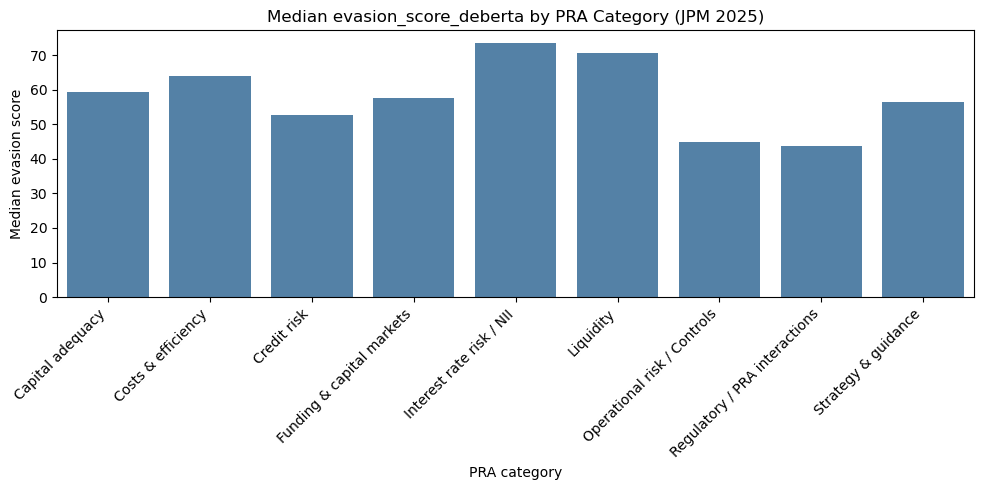

In [86]:
# Median evasion score by PRA category.
# Pick the score you care about
score_col = 'evasion_score_deberta'  # or 'evasion_score_deberta', 'evasion_score_baseline'

# Median by PRA category
pra_medians = jpm_2025_predictions_pra.groupby('pra_category')[score_col].median().reset_index()
pra_medians = pra_medians.drop(index=9)

plt.figure(figsize=(10,5))
sns.barplot(data=pra_medians, x='pra_category', y=score_col, color="steelblue")
plt.xticks(rotation=45, ha="right")
plt.title(f"Median {score_col} by PRA Category (JPM 2025)")
plt.ylabel("Median evasion score")
plt.xlabel("PRA category")
plt.tight_layout()
plt.show()

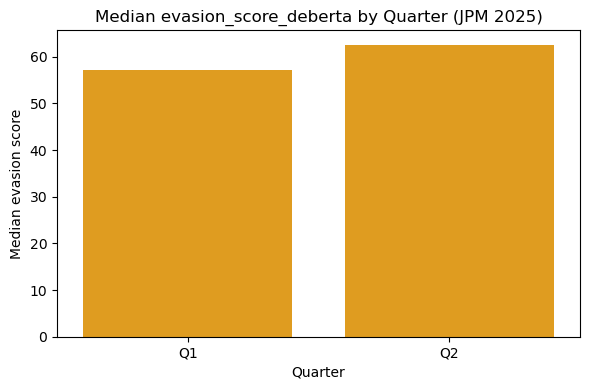

In [85]:
# Median evasion score by quarter.
quarter_medians = jpm_2025_predictions_pra.groupby('quarter')[score_col].median().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(data=quarter_medians, x='quarter', y=score_col, color="orange")
plt.title(f"Median {score_col} by Quarter (JPM 2025)")
plt.ylabel("Median evasion score")
plt.xlabel("Quarter")
plt.tight_layout()
plt.show()

## **6.2 HSBC**

### **6.2.1 Data Preprocessing**

In [139]:
# Load dataset
all_hsbc_2023_2025 = pd.read_csv('../data/processed/hsbc/all_hsbc_2023_2025.csv')

# View dataset.
display(all_hsbc_2023_2025.head())

# Number of rows.
print('Number of rows:', all_hsbc_2023_2025.shape[0])

,section,question_number,answer_number,speaker_name,role,company,content,year,quarter,is_pleasantry,source_pdf
0,presentation,NaN,NaN,Noel Quinn,Group Chief Executive,HSBC,"Thanks, Richard, and good morning in London, g...",2023,Q1,False,230502-1q-2023-hsbc-presentation-to-investors-...
1,presentation,NaN,NaN,Georges Elhedery,Group Chief Executive,HSBC,"Thank you, Noel, and a warm welcome to all of ...",2023,Q1,True,230502-1q-2023-hsbc-presentation-to-investors-...
2,qa,1.0,NaN,Joseph Dickerson,Analyst,Jefferies,"Good morning, gentlemen . Congrats on a good s...",2023,Q1,False,230502-1q-2023-hsbc-presentation-to-investors-...
3,qa,NaN,1.0,Georges Elhedery,management,HSBC,"Thank you, Joe . So first, we are hoping to ac...",2023,Q1,True,230502-1q-2023-hsbc-presentation-to-investors-...
4,qa,2.0,NaN,Raul Sinha,Analyst,JP Morgan,"Good morning, gents . Thanks very much for tak...",2023,Q1,False,230502-1q-2023-hsbc-presentation-to-investors-...


Number of rows: 376


In [140]:
# Remove pleasantries.
all_hsbc_2023_2025_cleaned = all_hsbc_2023_2025[all_hsbc_2023_2025['is_pleasantry'] == False]
print('Number of rows:', all_hsbc_2023_2025_cleaned.shape[0])

Number of rows: 245


In [141]:
# Check content column.
print('Number of rows with no content:', all_hsbc_2023_2025_cleaned['content'].isna().sum())

Number of rows with no content: 0


In [142]:
# View roles.
all_hsbc_2023_2025_cleaned['role'].unique()

array(['Group Chief Executive', 'Analyst', 'management', nan,
       'Interim Group Chief Financial Officer',
       'Group Chief Financial Officer'], dtype=object)

In [143]:
# Number of rows without role information.
print('Number of NaN roles:', all_hsbc_2023_2025_cleaned['role'].isna().sum())

Number of NaN roles: 33


In [144]:
# Drop rows without role information.
all_hsbc_2023_2025_cleaned = all_hsbc_2023_2025_cleaned.dropna(subset=['role']).reset_index(drop=True)
print('Number of NaN roles:', all_hsbc_2023_2025_cleaned['role'].isna().sum())

Number of NaN roles: 0


In [145]:
# Normalise role names.
role_map = {
    'Group Chief Executive': 'banker',
    'Interim Group Chief Financial Officer': 'banker',
    'Group Chief Financial Officer': 'banker',
    'management': 'banker',
    'Analyst': 'analyst'
}

# Map roles.
all_hsbc_2023_2025_cleaned['role_normalised'] = all_hsbc_2023_2025_cleaned['role'].map(role_map)

In [146]:
# View dataset.
display(all_hsbc_2023_2025_cleaned.head())
print('Number of rows:', all_hsbc_2023_2025_cleaned.shape[0])

,section,question_number,answer_number,speaker_name,role,company,content,year,quarter,is_pleasantry,source_pdf,role_normalised
0,presentation,NaN,NaN,Noel Quinn,Group Chief Executive,HSBC,"Thanks, Richard, and good morning in London, g...",2023,Q1,False,230502-1q-2023-hsbc-presentation-to-investors-...,banker
1,qa,1.0,NaN,Joseph Dickerson,Analyst,Jefferies,"Good morning, gentlemen . Congrats on a good s...",2023,Q1,False,230502-1q-2023-hsbc-presentation-to-investors-...,analyst
2,qa,2.0,NaN,Raul Sinha,Analyst,JP Morgan,"Good morning, gents . Thanks very much for tak...",2023,Q1,False,230502-1q-2023-hsbc-presentation-to-investors-...,analyst
3,qa,NaN,2.0,Noel Quinn,management,HSBC,Just one additional comment from me . You’ll n...,2023,Q1,False,230502-1q-2023-hsbc-presentation-to-investors-...,banker
4,qa,NaN,1.0,Noel Quinn,management,HSBC,"Thanks, Manus. Just on the asset quality of S...",2023,Q1,False,230502-1q-2023-hsbc-presentation-to-investors-...,banker


Number of rows: 212


In [147]:
# Save the cleaned dataset.
all_hsbc_2023_2025_cleaned.to_csv('../data/processed/hsbc/cleaned/all_hsbc_2023_2025_cleaned') 

In [156]:
# Load qa pairs dataset.
all_hsbc_2023_2025_qa = pd.read_csv('../data/processed/hsbc/cleaned/hsbc_qa_pairs_manual_seq.csv')

# View number of examples.
print('Number of examples:', all_hsbc_2023_2025_qa.shape[0])

Number of examples: 130


In [157]:
# Split into prediction set and test set.
hsbc_2025_predict_qa = all_hsbc_2023_2025_qa[all_hsbc_2023_2025_qa['year'] == 2025]
hsbc_2023_2024_qa = all_hsbc_2023_2025_qa[all_hsbc_2023_2025_qa['year'].isin([2023, 2024])]

# Save the datasets.
hsbc_2025_predict_qa.to_csv('../data/processed/hsbc/cleaned/hsbc_2025_predict_qa.csv') 
hsbc_2023_2024_qa.to_csv('../data/processed/hsbc/cleaned/hsbc_2023_2024_qa.csv') 

The hsbc_2023_2024_qa dataset was then manually labelled according to whether the banker's answer was deemed 'Direct' or 'Evasive'. The label was appended by a new column 'label'.

In [161]:
# Load the labelled dataset.
hsbc_2023_2024_qa_labelled = pd.read_csv('../data/processed/hsbc/cleaned/hsbc_2023_2024_qa_labelled.csv')

In [ ]:
# Define the LLM WEIGHT and selected LLM model
LLM_WEIGHT = 0.625
SELECTED_LLM = 'deberta'

In [163]:
# Generate raw evasion scores.
hsbc_2023_2024_qa_scores = evasion_pipeline_test(
    df=hsbc_2023_2024_qa_labelled,
    models_and_tokenizers=models_and_tokenizers,
    device=device,
    llm_weight=LLM_WEIGHT,
    llm_name=SELECTED_LLM,
    avg_llm=True        # also compute evasion_score_llm_avg
)

In [164]:
# Define the best threshold based on jpm validation set.
BLENDED_THR = 43
DEBERTA_THR = 56
BASELINE_THR = 21
AVG_LLM_THR = 46

In [168]:
# ==== A) RANKING METRICS ON HSBC (with 1 positive) ====
# Use your dataframe that has the scores + manual labels
df = hsbc_2023_2024_qa_scores.copy()   # <- adapt if your variable is different
score_col = 'evasion_score_blended_deberta'    # pick the model you want to rank by

# Map labels to binary
df['y'] = (df['label'].astype(str).str.lower() == 'evasive').astype(int)

n = len(df)
npos = int(df['y'].sum())
print(f"N={n}, positives={npos}")

# Sort by score descending, compute rank
df = df.sort_values(score_col, ascending=False).reset_index(drop=True)
df['rank'] = np.arange(1, n+1)

# if npos == 1:
r = int(df.loc[df['y'] == 1, 'rank'].iloc[0])
ap = 1.0 / r                           # AP with one positive
pct = 100.0 * (n - r + 1) / n          # higher = better (top-ranked => ~100%)
print(f"Positive at rank {r}/{n} (percentile {pct:.1f}%). AP={ap:.3f}")

# Hit@K / Success@K
Ks = [5, 10, max(1, int(0.10*n)), max(1, int(0.25*n))]
for K in sorted(set(Ks)):
    hit = int(r <= K)
    print(f"Hit@{K}: {hit}  (1 means the positive is in top {K})")


# ==== B) APPLY FIXED JPM THRESHOLDS TO CREATE PREDICTED LABELS ====
# Set your FIXED thresholds (from JPM tuning) here:
BLENDED_THR = 43
DEBERTA_THR = 56
BASELINE_THR = 21
AVG_LLM_THR = 46

# Create predicted label columns (string labels)
hsbc_test_qa_preds = hsbc_2023_2024_qa_scores.copy()
hsbc_test_qa_preds['pred_label_baseline'] = compute_evasion_labels(hsbc_test_qa_preds, 'evasion_score_baseline', BASELINE_THR)
hsbc_test_qa_preds['pred_label_deberta'] = compute_evasion_labels(hsbc_test_qa_preds, 'evasion_score_deberta', DEBERTA_THR)
hsbc_test_qa_preds['pred_label_llm_avg'] = compute_evasion_labels(hsbc_test_qa_preds, 'evasion_score_llm_avg', AVG_LLM_THR)
hsbc_test_qa_preds['pred_label_blended_deberta'] = compute_evasion_labels(hsbc_test_qa_preds, 'evasion_score_blended_deberta', BLENDED_THR)

# Outcome check per model: flagged count, caught the positive?
for name, col in [
    ('baseline', 'pred_label_baseline'),
    ('deberta', 'pred_label_deberta'),
    ('llm_avg', 'pred_label_llm_avg'),
    ('blended_deberta', 'pred_label_blended_deberta'),
]:
    flagged = int((hsbc_test_qa_preds[col] == 'Evasive').sum())
    caught = int(((hsbc_test_qa_preds[col] == 'Evasive') & (hsbc_test_qa_preds['label'].str.lower() == 'evasive')).sum())
    print(f"[{name}] flagged={flagged} | caught_positive={caught}")

N=96, positives=1
Positive at rank 25/96 (percentile 75.0%). AP=0.040
Hit@5: 0  (1 means the positive is in top 5)
Hit@9: 0  (1 means the positive is in top 9)
Hit@10: 0  (1 means the positive is in top 10)
Hit@24: 0  (1 means the positive is in top 24)
[baseline] flagged=76 | caught_positive=1
[deberta] flagged=18 | caught_positive=0
[llm_avg] flagged=28 | caught_positive=0
[blended_deberta] flagged=47 | caught_positive=1


### **Generate Predictions**

In [ ]:
# Load prediction dataset.
hsbc_2025_predict_qa = pd.read_csv("../data/processed/hsbc/cleaned/hsbc_2025_predict_qa.csv")

In [ ]:
# Define the LLM WEIGHT and selected LLM model
LLM_WEIGHT = 0.625
SELECTED_LLM = 'deberta'

In [ ]:
hsbc_2025_predictions = evasion_pipeline_test(
    df=hsbc_2025_predict_qa,
    models_and_tokenizers=models_and_tokenizers,
    device=device,
    llm_weight=LLM_WEIGHT,
    llm_name=SELECTED_LLM,
    avg_llm=True
    )

In [ ]:
# Re-append quarter and year meta data.
hsbc_2025_predictions['year'] = hsbc_2025_predict_qa['year']
hsbc_2025_predictions['quarter'] = hsbc_2025_predict_qa['quarter']

In [ ]:
# Define the fixed thresholds.
BLENDED_THR = 43
DEBERTA_THR = 56
BASELINE_THR = 21
AVG_LLM_THR = 46

In [ ]:
# Generate predicted labels.
hsbc_2025_predictions['pred_label_baseline']         = compute_evasion_labels(hsbc_2025_predictions, 'evasion_score_baseline', BASELINE_THR)
hsbc_2025_predictions['pred_label_deberta']          = compute_evasion_labels(hsbc_2025_predictions, 'evasion_score_deberta',  DEBERTA_THR)
hsbc_2025_predictions['pred_label_llm_avg']          = compute_evasion_labels(hsbc_2025_predictions, 'evasion_score_llm_avg', AVG_LLM_THR)
hsbc_2025_predictions['pred_label_blended_deberta']  = compute_evasion_labels(hsbc_2025_predictions, 'evasion_score_blended_deberta', BLENDED_THR)

In [ ]:
# Save the results.
hsbc_2025_predictions.to_csv("../data/outputs/hsbc_2025_evasion_predictions.csv", index=False)

In [ ]:
# Map QAs to PRA risk categories.
hsbc_2025_predictions_pra = hsbc_2025_predictions.copy()
texts = (hsbc_2025_predictions_pra["question"].astype(str) + " " + hsbc_2025_predictions_pra["answer"].astype(str)).str.strip()
hsbc_2025_predictions_pra["pra_category"] = texts.map(classify_pra)
hsbc_2025_predictions_pra.to_csv("../data/outputs/hsbc_2025_predictions_pra.csv", index=False)